# Lab CMBLenses

## Model

In [1]:
] activate "/home/jaimerz/julia_repos/CMBLensingInferenceTestProblem"

  Activating project at `~/julia_repos/CMBLensingInferenceTestProblem`


In [2]:
using CMBLensing, CMBLensingInferenceTestProblem
using CUDA, LaTeXStrings, MCMCDiagnosticTools, Plots, ProgressMeter, Random, Zygote
using LinearAlgebra, Statistics
ENV["LINES"] = 10;

In [3]:
using Revise
using MCHMC

In [ ]:
prob = load_cmb_lensing_problem(storage = Array,
                                T = Float32,
                                Nside = 4);

MAP_joint:   0%|                                        |  ETA: N/A

In [ ]:
target = CMBLensingTarget(prob)

## Sample

In [ ]:
eps=0.00000001
L=sqrt(target.d)
spl=Sampler(;eps=eps, L=L)

In [ ]:
init = MCHMC.Get_initial_conditions(spl, target)
x, u, g, r, time = init

In [ ]:
x = target.prior_draw(0.0)
g = target.grad_nlogp(x) #.* target.d ./ (target.d - 1)

In [64]:
g

50-element Field-(f°,ϕ°,θ)-Tuple{LambertQUMap{Array{Float32, 3}}, LambertMap{Array{Float32, 2}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}:
   0.0
   0.0
   0.0
   ⋮
 -Inf
 -Inf

In [63]:
using ForwardDiff
ForwardDiff.gradient(target.nlogp, x)

LoadError: MethodError: no method matching ForwardDiff.Dual{ForwardDiff.Tag{MCHMC.var"#nlogp#68"{CMBLensingInferenceTestProblem.CMBLensingLogDensityProblem}, Float64}, Float64, 10}(::Float32, ::ForwardDiff.Partials{10, Float64})

[0mClosest candidates are:
[0m  ForwardDiff.Dual{T, V, N}(::Number) where {T, V, N}
[0m[90m   @[39m [35mForwardDiff[39m [90m~/.julia/packages/ForwardDiff/QdStj/src/[39m[90m[4mdual.jl:78[24m[39m
[0m  ForwardDiff.Dual{T, V, N}(::V, [91m::ForwardDiff.Partials{N, V}[39m) where {T, V, N}
[0m[90m   @[39m [35mForwardDiff[39m [90m~/.julia/packages/ForwardDiff/QdStj/src/[39m[90m[4mdual.jl:17[24m[39m
[0m  ForwardDiff.Dual{T, V, N}(::Any) where {T, V, N}
[0m[90m   @[39m [35mForwardDiff[39m [90m~/.julia/packages/ForwardDiff/QdStj/src/[39m[90m[4mdual.jl:77[24m[39m


In [57]:
prob.Ωstart

50-element Field-(f°,ϕ°,θ)-Tuple{LambertQUMap{Array{Float32, 3}}, LambertMap{Array{Float32, 2}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}:
  0.23362982273101807
  1.6145217418670654
 -1.8872356414794922
  ⋮
 -1.6094379124341003
  0.0

In [56]:
x

50-element Field-(f°,ϕ°,θ)-Tuple{LambertQUMap{Array{Float32, 3}}, LambertMap{Array{Float32, 2}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}:
 -0.07227730751037598
 -1.3216322660446167
  1.1293165683746338
  ⋮
 -1.6094379124341003
  0.0

In [50]:
samples = Sample(spl, target; num_steps=100)

100-element Vector{Vector{Float64}}:
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]
 ⋮
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]

In [11]:
inv_Λmass = Diagonal(Vector(diag(pinv(target.Λmass))))

50×50 Diagonal{Float64, Vector{Float64}}:
 -3.23241    ⋅         ⋅        ⋅    ⋅   …   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
   ⋅       -1.22161    ⋅        ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
   ⋅         ⋅       -1.67113   ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋮                                      ⋱            ⋮                   
   ⋅         ⋅         ⋅        ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅ 
   ⋅         ⋅         ⋅        ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0

In [12]:
t_samples = [inv_Λmass * sample for sample in samples]

100-element Vector{Vector{Float64}}:
 [-0.7551871395916634, -1.9723189052802728, 3.1538173403317966, 4.002882680622447, 0.8755425007242731, -5.3238740898662025, 1.4903320802348785, -3.753601808445803, 2.1242988657927775, 31.00419569585445  …  -1.1830538127260596e-25, -4.4406816847113836e-26, 3.862019960882333e-25, -4.537775331387858e-26, 1.550768321553277e-25, -2.273744709414322e-25, -5.56730132800159e-25, -1.134813527994128e-25, -1.6094379146765943, -2.0460997232745378e-9]
 [-0.7551871373309493, -1.9723189067027713, 3.1538173429447585, 4.0028826769567685, 0.8755425028947658, -5.323874091566734, 1.4903320807755973, -3.7536018096197683, 2.1242988663961895, 31.004195697877847  …  -5.507973518078783e-26, -5.883380470025228e-26, 3.0272229951612234e-25, 2.6639789664455496e-26, 5.862822515342514e-26, -2.317325177458785e-25, -8.006453590960349e-25, -1.2930225711762295e-25, -1.609437917018198, -4.18262891030926e-9]
 [-0.7551871349910971, -1.9723189081750527, 3.153817345649161, 4.00288267316271

## Plotting

In [13]:
Plots.default(fmt=:png, dpi=120, size=(500,300), legendfontsize=10)

In [14]:
rs = [sample[end] for sample in samples]
Aϕs = [sample[end-1] for sample in samples];

In [15]:
println(mean(exp.(rs)), " ", std(exp.(rs)))

0.99999988498352 6.675822001534503e-8


In [16]:
println(mean(exp.(Aϕs)), " ", std(exp.(Aϕs)))

0.1999999747807435 1.4640768055761184e-8


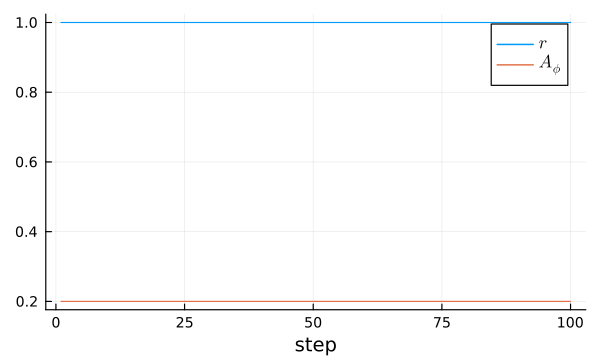

In [17]:
plot(exp.(rs), label=L"r", xlabel="step")
plot!(exp.(Aϕs), label=L"A_\phi")

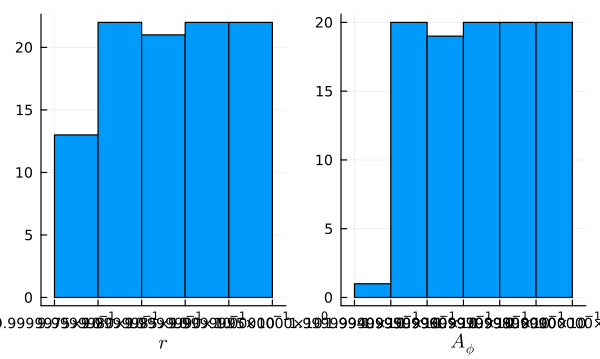

In [18]:
plot(histogram(exp.(rs), xlabel=L"r", label=nothing, lw=1),
    histogram(exp.(Aϕs), xlabel=L"A_\phi", label=nothing, lw=1))